# LGBMRegressor and fewer features

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import numpy as np
import itertools


df=pd.read_csv('Carbon_Emission.csv',sep=";")

#df = pd.read_csv('/kaggle/input/individual-carbon-footprint-calculation/Carbon Emission.csv')
#data can be found at https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation/data


# change display settings to show all columns
pd.set_option('display.max_columns', None)


#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')


df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


# Encoding

### variables "Transport" and "Vehicle Type"

In [6]:
##create new column "Transport Vehicle Type" 
df["Transport_Vehicle_Type"]=df["Vehicle_Type"] #create a new column
df.loc[df["Transport_Vehicle_Type"].isna(), "Transport_Vehicle_Type"] = df["Transport"] # Werte aus 'Transport' übernehmen, wenn 'Vehicle Type' NaN ist


##veranschaulichen der neuen Spalten und ihrer Werte
df[["Transport","Vehicle_Type","Transport_Vehicle_Type"]].head()

,Transport,Vehicle_Type,Transport_Vehicle_Type
0,public,NaN,public
1,walk/bicycle,NaN,walk/bicycle
2,private,petrol,petrol
3,walk/bicycle,NaN,walk/bicycle
4,private,diesel,diesel


### dummy-variables for: "Recycling" and "Cooking_With"

In [7]:
## dummy-variables for Recycling
unique_values_Recycling= set([item for sublist in df['Recycling'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Recycling-Möglichkeiten
for item in unique_values_Recycling:
    df['Recycling_'+str(item)] = df['Recycling'].apply(lambda x: 1 if item in x else 0)

## dummy-variables for Cooking-with
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Cooking_With-Möglichkeiten
unique_values_cooking_With.remove("Airfryer") #delete Cooking_with_Airfryer
for item in unique_values_cooking_With:
    df['Cooking_With_'+str(item)] = df['Cooking_With'].apply(lambda x: 1 if item in x else 0)

##########################################################################################

##create list of dummy-variables for Regression
dummy_variables = set()

columns_recycling=['Recycling_'+str(item) for item in unique_values_Recycling] #liste mit Spalten-Namen
dummy_variables.update(columns_recycling)

columns_cooking_with=['Cooking_With_'+str(item) for item in unique_values_cooking_With] #liste mit Spalten-Namen
dummy_variables.update(columns_cooking_with)

##########################################################################################


df.iloc[282:284, -13:] 

,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling_Metal,Recycling_Glass,Recycling_Plastic,Recycling_Paper,Cooking_With_Stove,Cooking_With_Microwave,Cooking_With_Grill,Cooking_With_Oven
282,No,"['Paper', 'Plastic', 'Metal']",[],1484,public,1,0,1,1,0,0,0,0
283,Yes,[],"['Stove', 'Grill', 'Airfryer']",2955,public,0,0,0,0,1,0,1,0


---

---
# 1.model: with all variables to find out the most important

In [66]:
variables_ordinal = ['Body_Type','Diet','How_Often_Shower','Social_Activity','Frequency_of_Traveling_by_Air','Waste_Bag_Size','Energy_efficiency']
variables_nominal_1answer = ['Sex', 'Heating_Energy_Source','Transport_Vehicle_Type']
variables_for_one_hot_encoded = variables_ordinal + variables_nominal_1answer 

variables_quantitative = ['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km', 'Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour']


X = df[variables_quantitative + variables_for_one_hot_encoded + list(dummy_variables)]

# Convert categorical columns to category dtype
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me

y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42
)
    
    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=categorical_features)

#evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_scores = r2_score(y_train, y_train_pred)
test_scores = r2_score(y_test, y_test_pred)
print(f"average R-squared (from train-set): {train_scores:.3f}")
print(f"average R-squared (from test-set): {test_scores:.3f}")


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_54981/4224525469.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 24
[LightGBM] [Info] Start training from score 2266.068750
average R-squared (from train-set): 0.992
average R-squared (from test-set): 0.980



Feature Importances:
                          feature  importance
4    How_Many_New_Clothes_Monthly         375
1     Vehicle_Monthly_Distance_Km         360
2          Waste_Bag_Weekly_Count         271
0            Monthly_Grocery_Bill         211
15         Transport_Vehicle_Type         176
13                            Sex         169
10  Frequency_of_Traveling_by_Air         167
6                       Body_Type         166
5    How_Long_Internet_Daily_Hour         161
11                 Waste_Bag_Size         150
14          Heating_Energy_Source         118
9                 Social_Activity         112
18                Recycling_Paper          87
7                            Diet          80
22                Recycling_Metal          69
12              Energy_efficiency          66
21                Recycling_Glass          57
3       How_Long_TV_PC_Daily_Hour          57
20              Recycling_Plastic          47
8                How_Often_Shower          33
19          

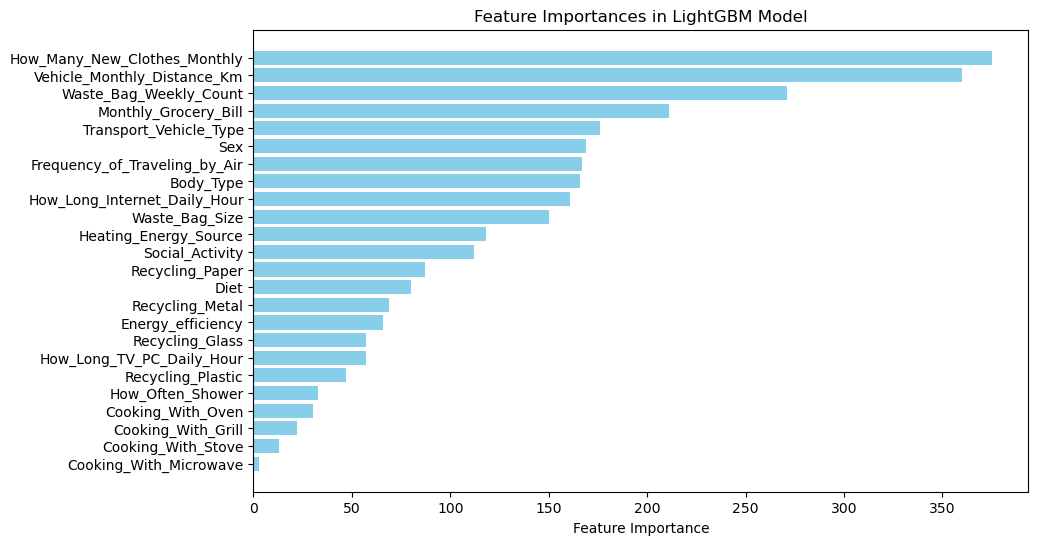

In [67]:
#chatGPT wrote this code-piece


# Extract and display feature importances
feature_importances = model.feature_importances_

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Displaying feature importances
print("\nFeature Importances:")
print(feature_importance_df)

# Optional: Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in LightGBM Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

---

---
# 2.model: with 6 most important features has only R^2 70%

In [68]:

variables_quantitative = ["Vehicle_Monthly_Distance_Km", "How_Many_New_Clothes_Monthly", "Waste_Bag_Weekly_Count",'Monthly_Grocery_Bill']
variables_for_one_hot_encoded = ['Body_Type', 'Transport_Vehicle_Type']
dummy_variables=set()


X = df[variables_quantitative + variables_for_one_hot_encoded + list(dummy_variables)]

# Convert categorical columns to category dtype
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me



y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42
)
    
    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=categorical_features)

#evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_scores = r2_score(y_train, y_train_pred)
test_scores = r2_score(y_test, y_test_pred)
print(f"average R-squared (from train-set): {train_scores:.3f}")
print(f"average R-squared (from test-set): {test_scores:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score 2278.201875


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_54981/1862815484.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


average R-squared (from train-set): 0.729
average R-squared (from test-set): 0.617


---

---
# 3.model: with different 6 features has R^2 90%

In [69]:
variables_quantitative =["Vehicle_Monthly_Distance_Km", "How_Many_New_Clothes_Monthly","Waste_Bag_Weekly_Count"]
variables_for_one_hot_encoded=['Frequency_of_Traveling_by_Air','Body_Type','Transport_Vehicle_Type']
dummy_variables=set()

#############

X = df[variables_quantitative + variables_for_one_hot_encoded + list(dummy_variables)]

# Convert categorical columns to category dtype
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42
)
    
    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=categorical_features)

#evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_scores = r2_score(y_train, y_train_pred)
test_scores = r2_score(y_test, y_test_pred)
print(f"average R-squared (from train-set): {train_scores:.3f}")
print(f"average R-squared (from test-set): {test_scores:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score 2274.361875


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_54981/2645837856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


average R-squared (from train-set): 0.911
average R-squared (from test-set): 0.863


---

# Find out which of the 28 6-element subsets of features has the best R-squared

In [9]:
#8 columns
name_columns=['How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km','Waste_Bag_Weekly_Count','Monthly_Grocery_Bill','Transport_Vehicle_Type','Sex','Frequency_of_Traveling_by_Air','Body_Type']

#list of all possible subsets with 6 elements
subsets6 = list(itertools.combinations(name_columns, 6))
print("Number of 6-element subsets:", len(subsets6))


results=[]
for columns_combination in subsets6:
    X = df[list(columns_combination)]

    # Convert categorical columns to category dtype
    variables_for_one_hot_encoded=X.select_dtypes(include=['object','category']).columns.tolist()
    X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


    y=df['CarbonEmission']
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75)


    # Specify the categorical features by column names
    categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
    model = LGBMRegressor()
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    #evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_scores = r2_score(y_train, y_train_pred)
    test_scores = r2_score(y_test, y_test_pred)

    results.append((test_scores,train_scores, columns_combination, len(columns_combination)))

# Setze die maximale Breite einer Spalte auf None, um keine Begrenzung zu haben
pd.set_option('display.max_colwidth', None)

# Create a dataframe to display results
results_df = pd.DataFrame(results, columns=['R-squared (from test-set)','R-squared (from train-set)', 'column-combination', 'number columns'])
results_df.sort_values(by='R-squared (from test-set)', ascending=False, inplace=True) #sort by Score
results_df

/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2272.998667


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2265.540267


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2267.547467


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2264.073467


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2267.802667


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2273.085333


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2263.562667


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me
/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2267.580933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2263.432667


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2280.390800


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2265.872667


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2279.832533


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2270.589200


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2274.321333


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2268.418133


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2271.424533


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me
/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2268.395733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2263.496000


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me
/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2274.850667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2256.928400


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2266.130000


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2271.338133


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2255.135600


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2270.852133


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2272.891867


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2270.781067


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2277.335733


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/337897619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2272.970133


,R-squared (from test-set),R-squared (from train-set),column-combination,number columns
14,0.878581,0.911051,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",6
8,0.869170,0.911267,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",6
25,0.867806,0.894688,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",6
12,0.852464,0.897223,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",6
6,0.850202,0.899565,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",6
26,0.841825,0.883733,"(Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",6
23,0.839399,0.883407,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",6
10,0.839084,0.883477,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",6
1,0.828164,0.885641,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air)",6
21,0.820698,0.870181,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",6


# 6 features with best R-Squared

In [11]:
columns_combination=['How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Sex','Frequency_of_Traveling_by_Air','Body_Type']

X = df[columns_combination]

    # Convert categorical columns to category dtype
variables_for_one_hot_encoded=X.select_dtypes(include=['object','category']).columns.tolist()
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


y=df['CarbonEmission']

#for final model no split in train-test-data
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75)


    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X, y, categorical_feature=categorical_features)

    #evaluate
y_pred = model.predict(X)
scores = r2_score(y, y_pred)
print('R-squared:',scores)


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_55963/926501616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 6
[LightGBM] [Info] Start training from score 2269.147300
R-squared: 0.9059859612112697


# save the model in pkl-format

In [ ]:

import pickle

#with open('model_LGBMRegressor.pkl', 'wb') as model_file:
#    pickle.dump(model, model_file)